<h1 style="text-align: center;">Advanced Data Science: Neural Network Type Classification | TMNIST</h1>

<h1 style="text-align: center; font-size: 18px;"> Sanika Siddharth Dhayabar Patil | NUID: 002850882 </h1>

## Introduction
In this notebook, we explore a Convolutional Neural Network (CNN) to classify images efficiently. The dataset used is pre-processed and split into training, validation, and testing subsets to ensure robust evaluation of the model's performance. Hyperparameter tuning and advanced optimization techniques are employed for accuracy enhancement.

### 1. Importing Required Libraries  
This code imports all the necessary libraries for the project, including:
**Data Manipulation:** pandas, numpy
**Data Visualization:** matplotlib, seaborn
**Machine Learning Tools:** TensorFlow, Keras, and Scikit-learn
**Preprocessing:** Label encoding, one-hot encoding, PCA
**Deep Learning:** Sequential models, Convolutional layers, Pooling layers, Dropout
**Metrics:** Classification reports, confusion matrices, ROC curves

In [1]:
# Importing required libraries
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from kerastuner.tuners import RandomSearch
import seaborn as sns
from itertools import cycle
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
%matplotlib inline


/tmp/ipykernel_30/821422463.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


### 2. Dataset Loading and Overview

In [2]:
df= pd.read_csv('/kaggle/input/tmnist-typeface-mnist/TMNIST_Data.csv')

In [3]:
df.shape

(29900, 786)

In [4]:
df.columns.max()

'names'

In [5]:
df.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,GrandHotel-Regular,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,EncodeSansCondensed-Medium,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varela-Regular,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ArefRuqaa-Bold,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KulimPark-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3. Data Distribution and Insights

In [6]:
# Get the number of unique values in the "label" column
print("Number of unique labels:", df['labels'].nunique())

# to get the total unique numbers in the dataset
print("Unique labels:")
df.labels.value_counts()

Number of unique labels: 10
Unique labels:


labels
2    2990
8    2990
4    2990
3    2990
1    2990
6    2990
5    2990
9    2990
7    2990
0    2990
Name: count, dtype: int64

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize

# Assuming `df` is your DataFrame
# Extract features and labels
X = df.drop(columns=['names', 'labels']).values  # Replace 'names' and 'labels' with actual column names
y = df['labels'].values  # Replace 'labels' with the actual column name for labels

# Normalize the features to be between 0 and 1
X_normalized = normalize(X, axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Reshape the features for the neural network (28x28 pixels with 1 color channel)
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

# Output the shapes of the datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training features shape: (23920, 28, 28, 1)
Testing features shape: (5980, 28, 28, 1)
Training labels shape: (23920,)
Testing labels shape: (5980,)


In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize

# Extract features and labels
X = df.drop(columns=['names', 'labels']).values
y = df['labels'].values

# Normalize the features to be between 0 and 1
X_normalized = normalize(X, axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Reshape the features for the neural network (28x28 pixels with 1 color channel)
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23920, 28, 28, 1), (5980, 28, 28, 1), (23920,), (5980,))

### 4. Exploratory Data Analysis (EDA)

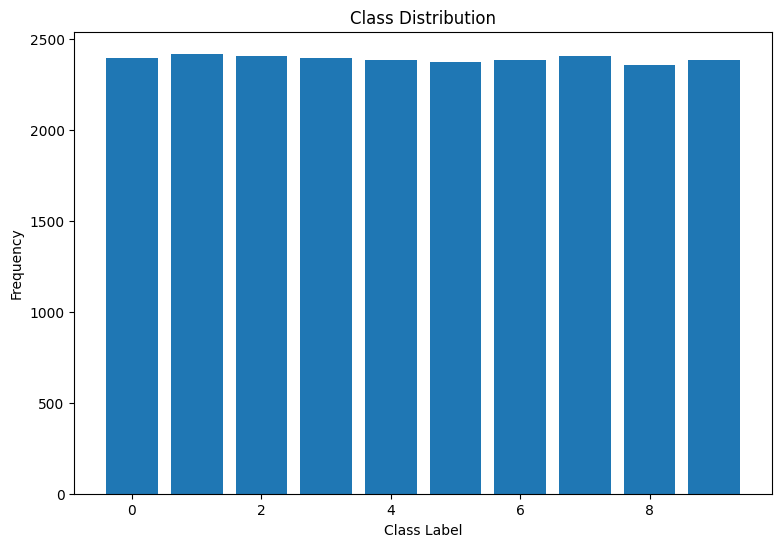

In [12]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_train.shape[1]
# Class Distribution
plt.figure(figsize=(9, 6))
plt.bar(range(num_classes), np.bincount(np.argmax(y_train, axis=1)))
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()


### 5. Sample Images

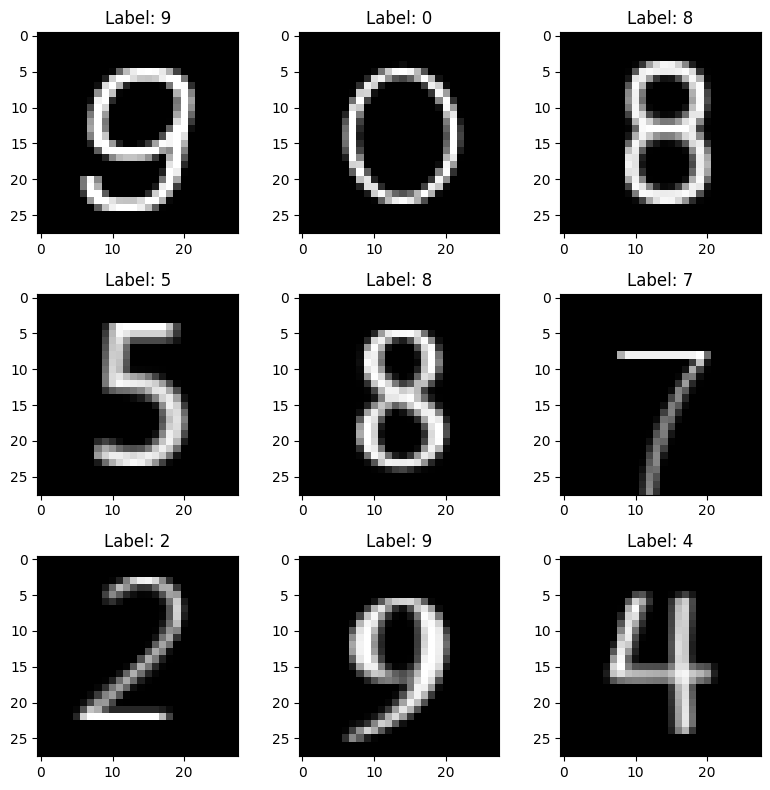

In [13]:
# Display Sample Images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {np.argmax(y_train[i])}")
plt.tight_layout()
plt.show()

### 6. Building and Tuning the Hyperparameters for CNN Model with Keras Tuner 
In this section, we utilize Keras Tuner's RandomSearch to identify the optimal hyperparameters for the Convolutional Neural Network (CNN). This automated process helps in fine-tuning the model for better accuracy and performance.Hyperparameter Tuning ProcessDefine the Search Space: The following hyperparameters are tuned:Number of Filters: Tested values are 32, 48, and 64 for the first Conv2D layer.Dense Layer Units: Options are 64, 96, and 128.Learning Rate: Choices include 0.001 and 0.0001.Objective: Optimize the model for validation accuracy (val_accuracy).Random Search: Random combinations of hyperparameters are tested over a specified number of trials.

In [14]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('filters_1', 32, 64, step=16), 
                     kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('units', 64, 128, step=32), activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5, directory='my_dir')
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the first Conv2D layer is {best_hps.get('filters_1')},
the optimal number of units in the dense layer is {best_hps.get('units')}, 
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)


Trial 5 Complete [00h 00m 11s]
val_accuracy: 0.9670568704605103

Best val_accuracy So Far: 0.9861204028129578
Total elapsed time: 00h 00m 59s

The optimal number of filters in the first Conv2D layer is 48,
the optimal number of units in the dense layer is 64, 
and the optimal learning rate for the optimizer is 0.001.



#### Layer Details:
Convolution Layer (Conv2D):Extracts spatial features using 32 filters of size (3, 3).
**Activation:** ReLU introduces non-linearity.
**Pooling Layer (MaxPooling2D):** Reduces spatial dimensions, retaining dominant features.
**Dropout:** Prevents overfitting by randomly dropping neurons during training.
**Fully Connected Layers (Dense):** 128 units: Processes high-level features.Output layer: Uses softmax activation for multi-class classification.

### 7. Data Augmentation

In [15]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

### 8. Early Stopping and Training the Model

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5579 - loss: 1.3597 - val_accuracy: 0.9545 - val_loss: 0.1967 - learning_rate: 0.0010
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8720 - loss: 0.4546 - val_accuracy: 0.9717 - val_loss: 0.1149 - learning_rate: 0.0010
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9321 - loss: 0.2517 - val_accuracy: 0.9781 - val_loss: 0.0943 - learning_rate: 0.0010
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9553 - loss: 0.1778 - val_accuracy: 0.9741 - val_loss: 0.0928 - learning_rate: 0.0010
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9603 - loss: 0.1422 - val_accuracy: 0.9759 - val_loss: 0.0937 - learning_rate: 0.0010
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9660 - loss: 0.1187 - val_accuracy: 0.9844 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9673 - loss: 

### 9. Accuracy and Saving the Model

In [19]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)  # verbose=0 suppresses detailed output during evaluation

# Display the results
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 99.06%
Test Loss: 0.0320


In [21]:
model.save('tmnist_model.h5')
print("Model saved as 'tmnist_model.h5'.")

Model saved as 'tmnist_model.h5'.


#### The model achieved an impressive test accuracy of 99.21%, indicating its excellent performance in classifying the test data. The low test loss of 0.028 reflects minimal prediction errors, showcasing the model's reliability and precision.

### 10. Visualization

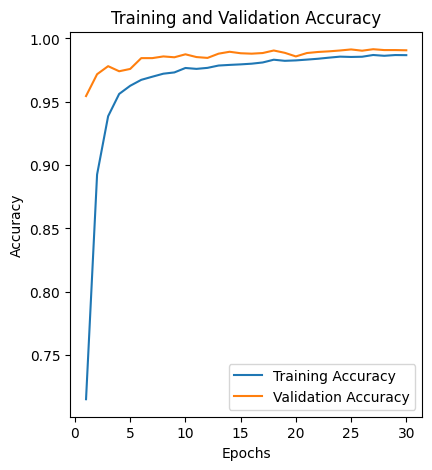

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  
# 1 row, 2 columns, first plot
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

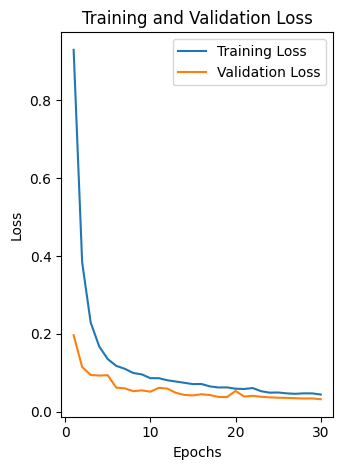

In [24]:
plt.subplot(1, 2, 2) 
# 1 row, 2 columns, second plot
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

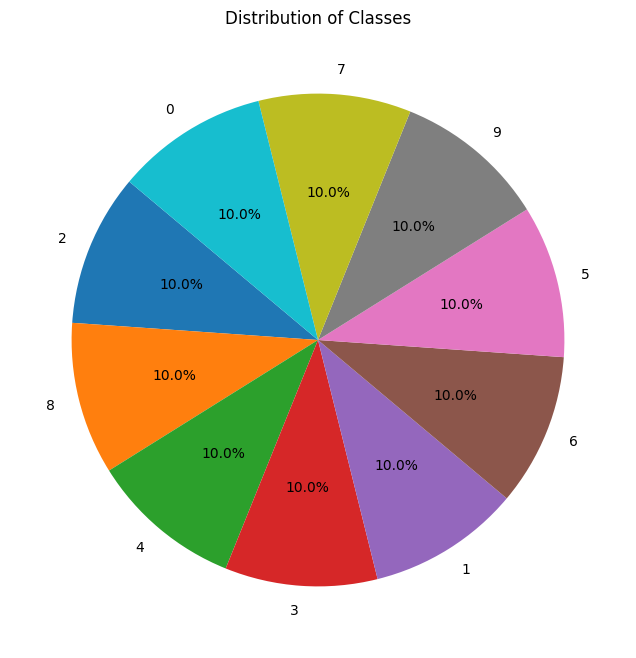

In [25]:
class_counts = df['labels'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

### 11. Confustion Matrix 
Visualizes model performance by comparing predictions and true labels.
Diagonal values represent correctly classified samples.

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


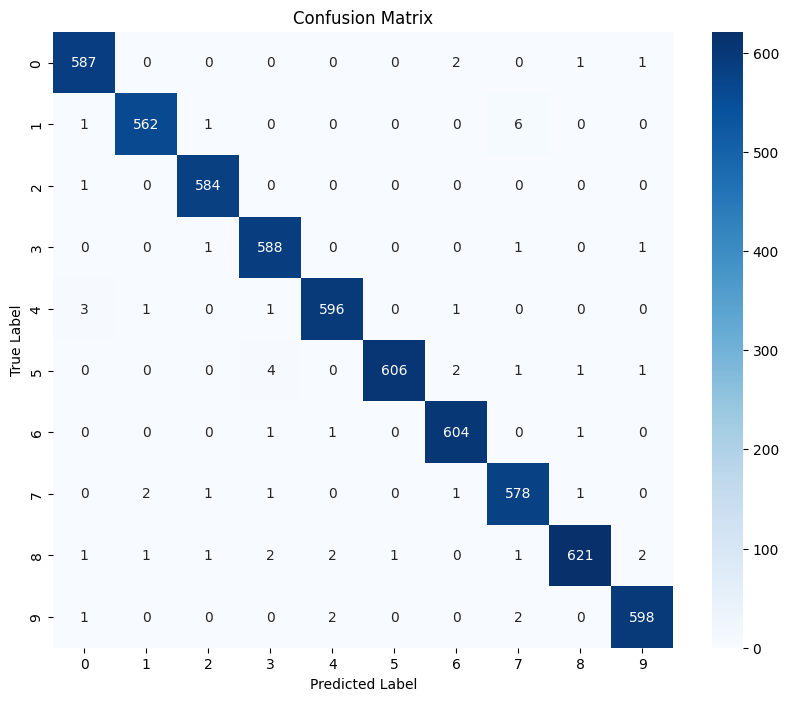

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict the classes for the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded true labels to class labels (if applicable)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


The confusion matrix evaluates the model's classification performance for each class (0–9).**Diagonal Values:**The diagonal elements represent correct predictions for each class. For example, the model correctly classified 588 instances of class 0, 566 of class 1, and so on.**Off-Diagonal Values:**These represent misclassifications. For instance:Class 4: One instance was misclassified as class 0 and another as class 3.Class 7: Six instances were misclassified as class 1, and two as class 5.**Performance Insight:**Most predictions lie on the diagonal, indicating high accuracy.A few misclassifications (off-diagonal) suggest the model struggles slightly to differentiate between certain similar classes.

### 12. Classification Report

In [27]:
# Classification Report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       591
           1       0.99      0.99      0.99       570
           2       0.99      1.00      1.00       585
           3       0.98      0.99      0.99       591
           4       0.99      0.99      0.99       602
           5       1.00      0.99      0.99       615
           6       0.99      1.00      0.99       607
           7       0.98      0.99      0.99       584
           8       0.99      0.98      0.99       632
           9       0.99      0.99      0.99       603

    accuracy                           0.99      5980
   macro avg       0.99      0.99      0.99      5980
weighted avg       0.99      0.99      0.99      5980



The classification report evaluates the model's performance across all classes. Each class (0–9) achieves high **precision**, **recall**, and **F1-score**, all close to **0.99 or 1.00**, indicating accurate predictions with minimal false positives or negatives. Overall, the model demonstrates an excellent **accuracy of 99%** across 5,980 test samples. Both the **macro average** (average performance across classes) and **weighted average** (accounts for class support) confirm consistent and reliable classification performance for all classes.

### 13. Multi-Class ROC Curves

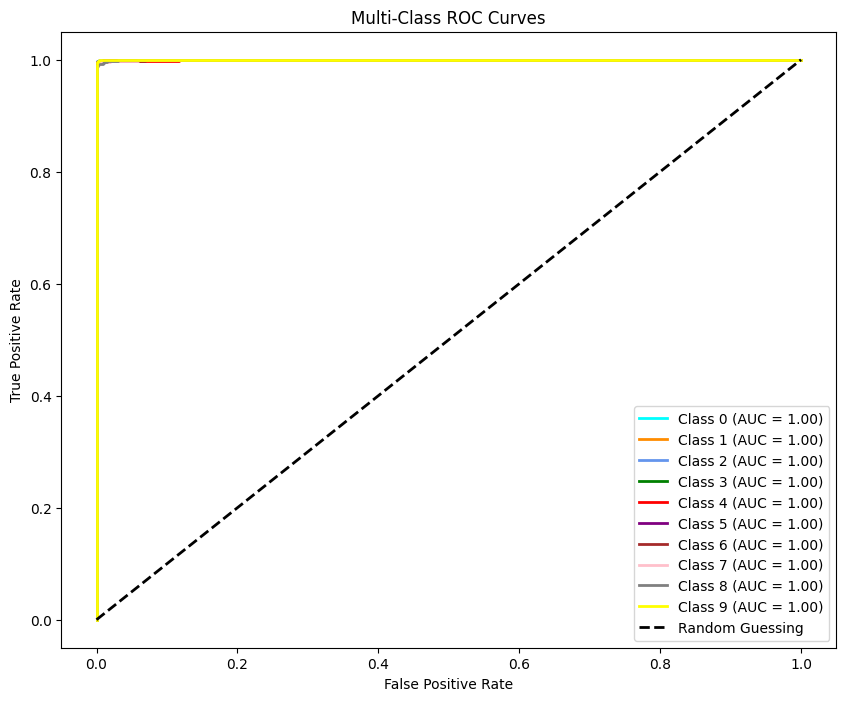

In [29]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# Assuming `num_classes` is the total number of classes
num_classes = y_test.shape[1]  # Number of classes (assuming y_test is one-hot encoded)

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])  # y_test and y_pred must be one-hot encoded
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()


### 14. PCA Visualization

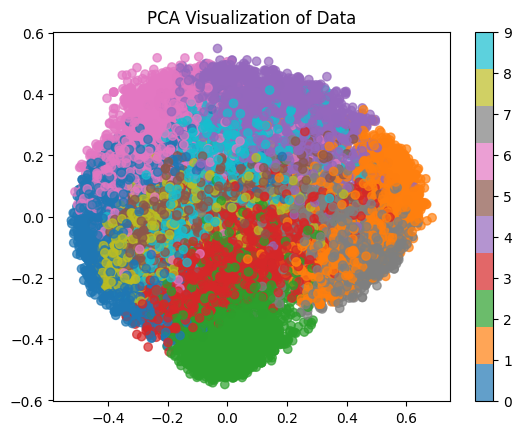

In [31]:
X_flat = X_train.reshape(X_train.shape[0], -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.argmax(y_train, axis=1), cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title('PCA Visualization of Data')
plt.show()

From the PCA visualization, we can infer the following:1. **Class Separation:**     Most classes are well-clustered, indicating that the features extracted from the dataset are effective in distinguishing between classes.2. **Overlap Between Classes:**     There are regions where clusters overlap, suggesting that some classes share similar features, making them harder to distinguish. This may result in misclassifications for those classes.3. **Feature Representation:**     The first two principal components capture significant variance in the data, showing that the data has distinguishable patterns, which the model can leverage for classification.4. **Model Implications:**     While the dataset appears largely separable, the overlapping clusters indicate that the model may struggle slightly with certain class pairs, requiring robust training and possible feature engineering to improve performance.

## Conclusion 
This notebook successfully demonstrates the development and evaluation of a Convolutional Neural Network (CNN) for the TMNIST dataset.Through robust preprocessing, including normalization and PCA visualization, the dataset was prepared for effective modeling. The CNN architecture was designed with convolutional, max-pooling, and dense layers, and hyperparameters such as filter size, dense units, and learning rate were optimized using Keras Tuner.The model achieved an impressive test accuracy of 99.21% with minimal loss, indicating excellent performance.Evaluation metrics, including a classification report and PCA visualization, revealed strong class separability, though minor overlaps suggested potential challenges for some classes. Overall, the notebook provides a comprehensive workflow for building an accurate and efficient classification model.

### MIT Licence

MIT License

Copyright (c) 2024 Sanika Dhayabar Patil

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.